# Monte Carlo Methods III: Parameter Estimation and Markov Chain

This hands-on is based on [Gravitational Wave Open Data Workshop 2024](https://github.com/gw-odw/odw-2024/).

In [1]:
# Let's make sure we have the necessary packages installed

! pip install corner tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# And import all packages at the beginning...

import os
import numpy as np

from matplotlib import pyplot as plt
from corner import corner
from tqdm import tqdm

## Introduction

Gravitational waves are ripples in spacetime predicted by Albert Einstein's General Theory of Relativity.
These waves propagate outward from sources such as merging black holes, neutron star collisions, or rapidly rotating neutron stars.
The first direct detection of gravitational waves, GW150914, was observed by the LIGO detectors in 2015, opening a new window into observing astrophysical phenomena previously inaccessible by electromagnetic observations alone.

Detecting and analyzing gravitational waves allows astronomers and physicists to study objects and phenomena that emit very little or no light, providing valuable insights into the behavior of gravity in extreme environments and the properties of dense objects like black holes and neutron stars.

In this hands-pon, we introduce Bayesian inference methods for estimating the parameters of gravitational wave signals detected by instruments such as LIGO and Virgo.
Specifically, we'll demonstrate parameter estimation using both a rejection method and Markov chain Monte Carlo.

## Bayesian Inference

Recalling that Bayesian inference allows us to update our knowledge of model parameters based on observed data.
Bayes' theorem mathematically represents this process:
\begin{align}
  p(\theta|d,M) = \frac{\mathcal{L}(d|\theta,M) \pi(\theta|M)}{\mathcal{Z}(d|M)}
\end{align}
where:
* $p(\theta|d, M)$ is the posterior distribution.
* $\mathcal{L}(d|\theta, M)$ is the likelihood function, measuring agreement between model predictions and observed data.
* $\pi(\theta|M)$ is the prior distribution, representing previous knowledge.
* $\mathcal{Z}(d|M)$ is the evidence, normalizing the posterior.

Typically, the posterior cannot be computed analytically, requiring computational approximations.
Stochastic (Monte Carlo) sampling is a common method for this purpose.

## Toy Model

We download sample observational data (`toy_model.csv`) containing simulated time-series observations:

In [3]:
if not os.path.isfile("toy_model.csv"):
    print("Downloading toy_model.csv")
    ! wget https://raw.githubusercontent.com/gw-odw/odw-2024/main/Tutorials/Day_3/toy_model.csv
else:
    print("toy_model.csv exists; not downloading")

--2025-04-08 19:40:31--  https://raw.githubusercontent.com/gw-odw/odw-2024/main/Tutorials/Day_3/toy_model.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5104 (5.0K) [text/plain]
Saving to: ‘toy_model.csv’

toy_model.csv       100%[===================>]   4.98K  --.-KB/s    in 0s      

2025-04-08 19:40:31 (59.0 MB/s) - ‘toy_model.csv’ saved [5104/5104]



Our example data (`toy_model.csv`) contains measurements (`yobs`) recorded at specific times (`time`).
Let's visualize these observations:

In [4]:
time, yobs = np.genfromtxt("toy_model.csv", delimiter=",").T

Text(0.5, 1.0, 'Simulated Observational Data')

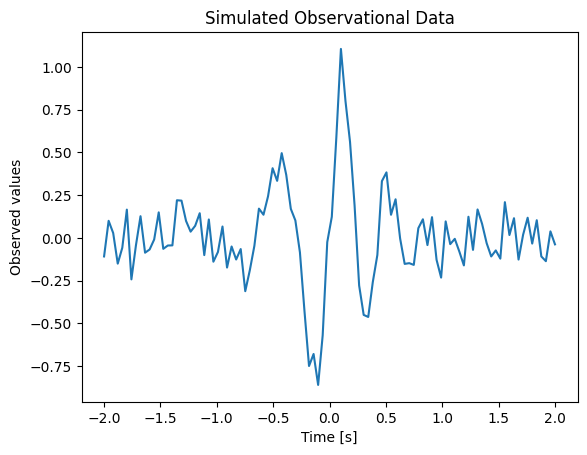

In [5]:
plt.plot(time, yobs)
plt.xlabel("Time [s]")
plt.ylabel("Observed values")
plt.title("Simulated Observational Data")

We propose the following sine-Gaussian model to explain the data:
\begin{align}
  s(t; f,\alpha) = e^{-(t/\alpha)^2} \sin(2\pi f t),
\end{align}
with frequency parameter $f$ and damping parameter $\alpha$.
To build intuition, we visualize this model for representative parameters:

In [6]:
def sinusoid(time, freq):
    return np.sin(2 * np.pi * freq * time)

def gaussian_exponential(time, alpha):
    return np.exp(-(time/alpha)**2)

def model_Ms(time, freq, alpha):
    return gaussian_exponential(time, alpha) * sinusoid(time, freq)

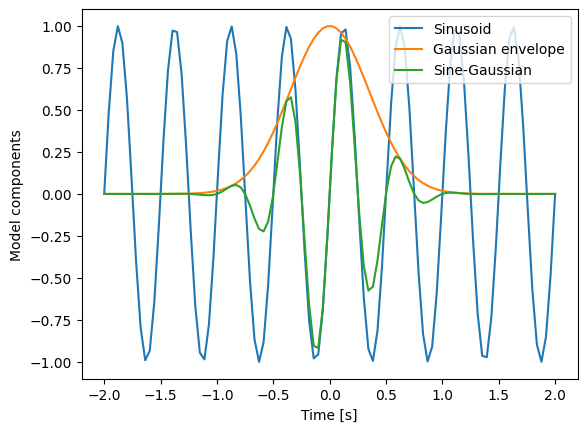

In [10]:
freq, alpha = 2, .5

plt.plot(time, sinusoid(time, freq), label="Sinusoid")
plt.plot(time, gaussian_exponential(time, alpha), label="Gaussian envelope")
plt.plot(time, model_Ms(time, freq, alpha), label="Sine-Gaussian")
plt.xlabel("Time [s]")
plt.ylabel("Model components")
plt.legend()

## Parameter Estimation with Rejection Method

With the data (`yobs`) and our model $M_s$, we can now estimate the parameters $f$ and $\alpha$.
To do this, similar to previous lectures, we will use Bayes theorem, i.e. we want to approximate the distribution
\begin{align}
p(\theta | d, M_s) = \frac{\mathcal{L}(d| \theta, M_s) \;\pi(\theta | M_s)}{\mathcal{Z}(d | M_s)}
\end{align}
where $\theta=\{f, \alpha\}$ is the two-dimensional parameter vector and $d$ is `yobs` (measured at times `time`).

To this end, we need to define the likelihood and priors.
Note that, if we are **only interested in the shape of the distribution**, then we can ignore the evidence, i.e. we can estimate the unnormalized distribution
\begin{align}
  p(\theta | d, M_s) \propto \mathcal{L}(d| \theta, M_s) \;\pi(\theta | M_s)
\end{align}

#### Parameter Estimation: Likelihood

For this toy example, we will assume that the data consists of the generate model $M_s$ and additive white Gaussian noise, i.e.
\begin{align}
y_{\rm obs}(t) = s(t; f, \alpha) + \epsilon
\end{align}
where $\epsilon \sim N(0, \sigma)$ by which we mean that $\epsilon$ is drawn from a Gaussian distribution with zero mean and standard deviation $\sigma=0.1$ (for now, we will assume this is known a priori, but see challenges below for how it could be estimated). 

This definition of how the data was created allows us to define our likelihood.
Namely, given a value of $\{f, \alpha\}$, the likelihood of a single data point $y_i$ (measured at $t_i$) is:
\begin{align}
\mathcal{L}(y_i| f, \alpha, M_s) = \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left(-\frac{(y_i - s(t_i; f, \alpha))^2}{2\sigma^2}\right)
\end{align}

To extend this to multiple data points, we assume they are independent then
\begin{align}
\mathcal{L}(y_{obs} | f, \alpha, M_s) = \prod_i \mathcal{L}(y_i| f, \alpha, M_s)
\end{align}
In practice, it is wise to work with the logarithm of the likelihood to avoid numerical overflow.
Then, we have that
\begin{align}
\log \mathcal{L}(y_{obs} | f, \alpha, M_s) = \sum_{i} -\frac{1}{2}\left(\frac{\left(y_i - s(t_i; f, \alpha)\right)^2}{\sigma^2} + \log\left(2\pi \sigma^2\right)\right)
\end{align}
We now transcribe this into `python`:

In [11]:
def log_likelihood_Ms(time, yobs, freq, alpha, sigma=0.1):
    prediction = model_Ms(time, freq, alpha)
    res  = yobs - prediction 
    logl = -0.5 * (((res/sigma)**2) + np.log(2 * np.pi * sigma**2))
    return np.sum(logl, axis=0)

#### Parameter Estimation: Priors

The second part of Bayes theorem is the *prior*.
For our two-component model, we will use a simple disjoint prior (i.e. $\pi(\theta | M_s)=\pi(f| M_s)\pi(\alpha | M_s)$) with
\begin{align}
  \pi(f     | M_s) &= \textrm{Uniform}(0, 5) \\
  \pi(\alpha| M_s) &= \textrm{Uniform}(0, 1)
\end{align}
Let us create a python function to calculate the log of the prior:

In [13]:
def log_prior_Ms(freq, alpha):
    """ Calculate the log prior under the Ms model
    
    Parameters
    ----------
    freq: array or float
        The frequency at which to calculate the prior
    alpha: array or float
        The alpha at which to calculate the prior
        
    Returns
    -------
    log_prior: array
        The log_prior calculated for all freq, alpha samples
    """
    # Convert freq, alpha to numpy arrays
    freq  = np.atleast_1d(freq)
    alpha = np.atleast_1d(alpha)
    
    # Apply Uniform priors: calculate idxs of array where f, alpha in range
    f_min = 0
    f_max = 5
    f_idxs = (freq > f_min) * (freq < f_max)
    
    alpha_min = 0
    alpha_max = 1
    alpha_idxs = (alpha > alpha_min) * (alpha < alpha_max)
    
    idxs = alpha_idxs * f_idxs
    
    log_prior_volume = np.log(1/(f_max - f_min) * (1 / (alpha_max - alpha_min)))
    
    log_prior = np.zeros_like(freq)
    log_prior[idxs] = log_prior_volume
    log_prior[~idxs] = -np.inf
    
    return log_prior

#### Parameter Estimation: Rejection Sampling

Now that we have our likelihood and prior, we will introduce **stochastic (i.e., Monte Carlo) sampling**.
We start by using the simplest type of stochastic sampling, rejection sampling.
The idea is that to draw samples from a target distribution $p(\theta | d, M_s)$ which is difficult to sample from, we first generate samples from a generating distribution $g(\theta$) which is easy to sample from and then weight the samples relative to the target distribution.
In practice you can choose any generating distribution you like, but we will use $g(\theta) = g(f)g(\alpha)$ where
\begin{align}
  g(f)      &= \textrm{Uniform}(1.8, 2.2) \\
  g(\alpha) &= \textrm{Uniform}(0.2, 0.6)
\end{align}

Our rejection sampling algorithm then proceeds as follows:

1. Draw $\theta'=[f, \alpha]$ from $g(f)$ and $g(\alpha)$
2. Calculate the probability under the target and generating distributions (i.e. $p(\theta' | d, M_s)$ and $g(\theta')$)
3. Calculate the weight $w=p(\theta' | d, M_s) / g(\theta')$
4. Draw a random number $u$ uniformly distributed in $[0, 1]$
5. If $w > u$, append $\theta'$ to a set of samples, otherwise reject it and repeat

Continue this loop until an acceptable number of samples have been drawn.
The resulting set of samples are then an approximation to $p(\theta | d, M_s)$ and be used to produce summary statistics or create plots. 

We now program the algorithm for our test data.
However, there are two important differences between this algorithm and the expression above:

1. We will work with the unnormalised distribution $p(\theta | d, M_s)$ (i.e. we don't calculate the evidence $\mathcal{Z}$).
   As a result, $w$ is also unnormalised and so it needs to be normalised before we apply step 5.
   Fortunately, we can normalize $w$ once we have a distribution of values.
2. For computational efficiency, rather than using a while loop we will instead draw a set of 100000 samples, calculate the weights for each, and then apply rejection sampling.
   This utilises numpy array optimization and also enables us to normalise the weights to a distribution.

In [14]:
def rejection_sampler(time, yobs, n_total=100_000):

    # Draw n_total samples from g(theta)
    freq_gsamples  = np.random.uniform(1.8, 2.2, n_total)
    alpha_gsamples = np.random.uniform(0.2, 0.6, n_total)

    # Make time a 2D array to enable broadcasting across the samples
    time_array = time[:, np.newaxis]
    yobs_array = yobs[:, np.newaxis]

    # Calculate the log_likelihood and log_prior for all samples
    log_post = log_likelihood_Ms(time_array, yobs_array, freq_gsamples, alpha_gsamples) + log_prior_Ms(freq_gsamples, alpha_gsamples)

    # Calculate the weights
    weights = np.exp(log_post)

    # Normalise the weights
    weights = weights / max(weights)

    # Rejection sample
    keep = weights > np.random.uniform(0, 1, weights.shape)
    alpha_samples = alpha_gsamples[keep]
    freq_samples  = freq_gsamples[keep]

    efficiency = len(freq_samples) / len(freq_gsamples)
    print(f'Efficiency: {efficiency}')
    
    return np.array([freq_samples, alpha_samples]).T

The end result of this is a set of samples `freq_samples` and `alpha_samples` that approximate the posterior distribution.

In [16]:
samples = rejection_sampler(time, yobs, n_total=100_000)

Efficiency: 0.02641


We can get a quick visualisation of these by using the `corner` package:

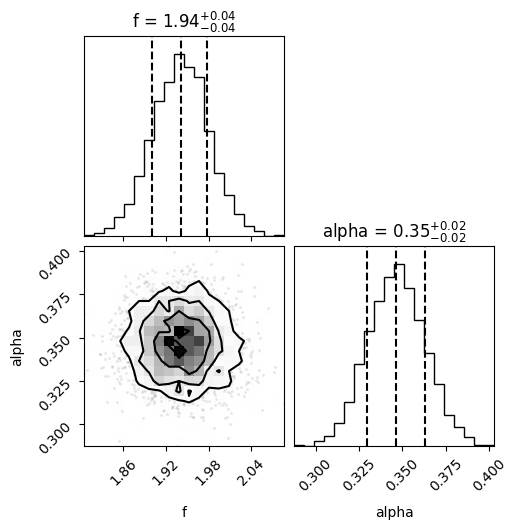

In [17]:
# Create a corner plot

fig = corner(samples, bins=20, labels=["f", "alpha"], show_titles=True, quantiles=[0.16, 0.5, 0.84])

The plot above shows two 1D histograms (one for each parameter) and one 2D histogram (showing any correlations between the samples).
Areas where the posterior is large (i.e. the histogram count is high) represent the most probable values of $f$ and $\alpha$ which explain the data.

The samples can also be used to provide a summary statistic.
For example, if you wanted to report the mean and standard deviation interval for $f$, you could do something like this: 

In [18]:
freq_samples, alpha_samples = samples.T

freq_mean = np.mean(freq_samples)
freq_std  = np.std (freq_samples)
print(f"We estimate the the mean and standard deviation of frequency to be {freq_mean:0.2f}+/-{freq_std:0.2f}")

alpha_mean = np.mean(alpha_samples)
alpha_std  = np.std (alpha_samples)
print(f"We estimate the the mean and standard deviation of alpha to be {alpha_mean:0.2f}+/-{alpha_std:0.2f}")

We estimate the the mean and standard deviation of frequency to be 1.94+/-0.04
We estimate the the mean and standard deviation of alpha to be 0.35+/-0.02


Typically, in GW astronomy, we use the median and a 90\% credible interval because the posterior is often non-symmetric.

In this exerise, we have learned that rejection sampling can be used to approximate the posterior distribution.
However, we should note that it is highly inefficienct.
It works okay here, because we tightly tuned the edges of $g(\theta)$, but if you go back and increase these to a wider range, you'll see the efficiency quickly drops off.
Moreover, the efficiency of rejection sampling also suffers when we start to look at problems in more than 2 parameters.

## Parameter Estimation with Markov Chain Monte Carlo

The rejection sampling algorithm is inefficient in problems where the posterior is small compared to the prior volume.
To address this, a range of stochastic sampling algorithms are available.
In GW astronomy, two are preferred: Markov Chain Monte Carlo (MCMC), and Nested Sampling.

We will implement our own simple Metropolis-Hastings MCMC algorithm here:

1. Start from an initial guess for the parameters, $\theta = [f, \alpha]$.
2. Propose new parameters $\theta'$ by adding a random perturbation drawn from a proposal distribution (often a Gaussian centered around the current parameters).
3. Calculate the posterior probabilities $p(\theta | d)$ and $p(\theta' | d)$.
4. Calculate the acceptance ratio $a = p(\theta' | d)/p(\theta | d)$.
5. Draw a random number $u$ uniformly distributed between $[0,1]$.
6. If $a > u$, accept the proposed parameters $\theta'$ as the new state; otherwise, retain the current state.
7. Repeat steps 2-6 until the desired number of samples is generated.

The resulting set of samples approximates the posterior distribution and can be used for parameter estimation and plotting.

In [ ]:
def mcmc_sampler(time, yobs, widths, n_steps=2_500):

    freq  = np.random.uniform(1.8, 2.2)
    alpha = np.random.uniform(0.2, 0.6)
    
    log_post = log_likelihood_Ms(time, yobs, freq, alpha) + log_prior_Ms(freq, alpha)

    samples = []
    progbar = tqdm(total=n_steps)
    n_total = 0
    while len(samples) < n_steps:
        # propose new parameters
        freq_proposed  = np.random.normal(freq,  widths[0])
        alpha_proposed = np.random.normal(alpha, widths[1])

        # calculate new posterior
        log_post_proposed = log_likelihood_Ms(time, yobs, freq_proposed, alpha_proposed) + log_prior_Ms(freq_proposed, alpha_proposed)

        # Metropolis acceptance criterion
        acceptance_prob = np.exp(log_post_proposed - log_post)

        if acceptance_prob > np.random.rand():
            freq, alpha = freq_proposed, alpha_proposed
            log_post    = log_post_proposed
            samples.append([freq, alpha])
            progbar.update(1)

        n_total += 1

    print(f'Efficiency: {n_steps/n_total}')
    return np.array(samples)

We can now run `mcmc_sampler()`:

In [ ]:
samples = mcmc_sampler(time, yobs, [0.02, 0.02])

The efficiency is much bettter!!!
What would happen to the efficiency if we adjust the widths?

The `mcmc_sampler` functions returns an numpy array `samples`.
This contains all the interesting information that we might want to use.
We can create the corner plot as before.

In [ ]:
fig = corner(samples, bins=20, labels=["f", "alpha"], show_titles=True, quantiles=[0.16, 0.5, 0.84])

Similar to the rejection method, we can compute some statistics:

In [ ]:
freq_samples, alpha_samples = samples.T

freq_mean = np.mean(freq_samples)
freq_std  = np.std (freq_samples)
print(f"We estimate the the mean and standard deviation of frequency to be {freq_mean:0.2f}+/-{freq_std:0.2f}")

alpha_mean = np.mean(alpha_samples)
alpha_std  = np.std (alpha_samples)
print(f"We estimate the the mean and standard deviation of alpha to be {alpha_mean:0.2f}+/-{alpha_std:0.2f}")

## Next Step

The Gravitational Wave Open Data Workshop has code for processing actual LIGO data.
Specifically, [this tutorial](https://github.com/gw-odw/odw-2024/blob/main/Tutorials/Day_3/Tuto_3.2_Parameter_estimation_for_compact_object_mergers.ipynb).
However, the code will take at least 30 minutes to run so we will not do it in class.
Please feel free to go through the tutorial yourself.